In [4]:
import os

from holoviews.streams import Tap
from matplotlib import animation
from matplotlib.colors import ListedColormap
from PIL import Image, ImageEnhance
from scipy.ndimage import gaussian_filter1d
from xarray.backends.api import open_datatree
import cartopy.crs as ccrs
import cmocean
import earthaccess
import holoviews as hv
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import panel.widgets as pnw
import xarray as xr

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
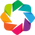

In [5]:
hv.extension("bokeh")

In [6]:
auth = earthaccess.login()
# are we authenticated?
if auth.authenticated:
    print("authenticated!")
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

authenticated!


In [7]:
results = earthaccess.search_datasets(instrument="oci")

In [8]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


In [9]:
tspan = ("2024-07-01", "2024-08-25")
bbox = (-170, 23, -140, 33)
clouds = (0, 50)

In [10]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/56 [00:00<?, ?it/s]

In [21]:
paths

[<File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240702.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240703.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240704.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240705.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240706.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatac

In [19]:
def spectrum(x, y):
    array = subset.sel({"lon": x, "lat": y}, method="nearest")
    return hv.Curve(array, kdims=["wavelength"]).redim.range(Rrs=(-0.01, 0.04))

# for i in range(1, 3):
#     # Open dataset
#     dataset = xr.open_dataset(paths[i])
#     dataset
#     # Subset the dataset within the specified region
#     subset = dataset.sel(lon=slice(-165, -156), lat=slice(30, 20))
#     spectrum(0, 0)
import xarray as xr

import xarray as xr

# Initialize an empty list to store the average subsets
average_subsets = []

for i in range(1, 56):
    # Open dataset
    dataset = xr.open_dataset(paths[i])
    
    # Subset the dataset within the specified region
    subset = dataset.sel(lon=slice(-165, -156), lat=slice(30, 20))
    
    # Drop NaN values along the 'lon' dimension (and optionally 'lat' if needed)
    # subset = subset.dropna(dim="lon", how='all')
    
    # Calculate the mean Rrs value across the subset for each wavelength
    average_subset = subset.mean(dim=['lon', 'lat'])
    
    # Expand the average_subset to include a new dimension "dataset_index"
    average_subset = average_subset.expand_dims(dim={"dataset_index": [i]})
    
    # Append the expanded average_subset to the list
    average_subsets.append(average_subset)

# Combine all the average subsets into a single xarray Dataset
combined_subset = xr.concat(average_subsets, dim="dataset_index")



IndexError: list index out of range

In [24]:

combined_subset

<xarray.Dataset> Size: 85kB
Dimensions:        (dataset_index: 55, wavelength: 184, rgb: 3,
                    eightbitcolor: 256)
Coordinates:
  * dataset_index  (dataset_index) int64 440B 1 2 3 4 5 6 ... 50 51 52 53 54 55
  * wavelength     (wavelength) float64 1kB 339.0 341.0 344.0 ... 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs            (dataset_index, wavelength) float32 40kB 0.01128 ... -0.00...
    palette        (dataset_index, rgb, eightbitcolor) uint8 42kB 147 0 ... 0 0

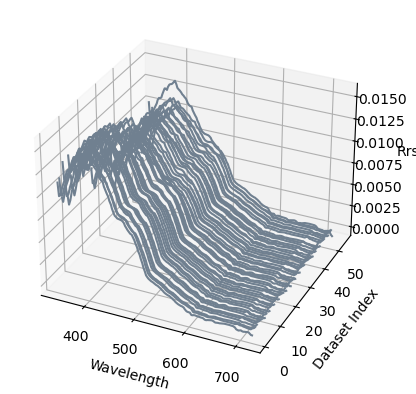

In [54]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Assuming combined_subset is already created
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop over the dataset_index dimension to extract the data for plotting
for i in combined_subset.dataset_index:
    # Get the dataset_index as an integer value
    dataset_index = i.item()
    
    # Extract the wavelength and Rrs values for this dataset
    wavelengths = combined_subset['wavelength'].values
    rrs_values = combined_subset.sel(dataset_index=dataset_index)['Rrs'].values
    
    # Use the dataset_index as the y-coordinate
    y = np.full_like(wavelengths, dataset_index)
    
    # Plot in 3D space using a single color (e.g., blue)
    ax.plot(wavelengths, y, rrs_values, color='slategray')

# Set axis labels
ax.set_xlabel('Wavelength')
ax.set_ylabel('Dataset Index')
ax.set_zlabel('Rrs')

# Rotate the plot 45 degrees along the Y-axis
ax.view_init(elev=30, azim = -65)

# Show the plot
plt.show()


In [49]:
subset = dataset.sel(lon=slice(-170, -150), lat=slice(30, 18))

In [50]:
subset

<xarray.Dataset> Size: 18MB
Dimensions:     (wavelength: 184, lat: 120, lon: 200, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 480B 29.95 29.85 29.75 29.65 ... 18.25 18.15 18.05
  * lon         (lon) float32 800B -169.9 -169.9 -169.8 ... -150.2 -150.1 -150.1
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 18MB ...
    palette     (rgb, eightbitcolor) uint8 768B 147 0 108 144 0 ... 0 0 0 0 0
Attributes: (12/64)
    product_name:                      PACE_OCI.20240704.L3m.DAY.RRS.V2_0.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/2.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         692139
    data_minimum:                      -0.0100000035
    data_maximum:                      0.1

In [58]:
def spectrum(x, y):
    array = subset.sel({"lon": x, "lat": y}, method="nearest")
    return hv.Curve(array, kdims=["wavelength"]).redim.range(Rrs=(-0.01, 0.04))

In [59]:
spectrum(-157.5, 20.13)

ValueError: Invalid fill method. Expecting pad (ffill), backfill (bfill) or nearest. Got average

In [57]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Initialize a figure for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop through datasets 1 to 3 (for testing)
for i in range(1, 3):
    # Open dataset
    dataset = xr.open_dataset(paths[i])
    
    # Subset the dataset within the specified region
    subset = dataset.sel(lon=slice(-165, -156), lat=slice(30, 20))
    
    # Calculate the mean Rrs value across the subset for each wavelength
    mean_rrs = subset.mean(dim=['lon', 'lat'])

    # Extract the wavelengths and mean Rrs values
    wavelengths = mean_rrs['wavelength'].values
    rrs_values = mean_rrs['Rrs'].values
    
    # Exclude NaN values
    valid_indices = ~np.isnan(rrs_values)
    wavelengths = wavelengths[valid_indices]
    rrs_values = rrs_values[valid_indices]
    
    # Use i as the z-coordinate (representing the dataset index)
    z = np.full_like(wavelengths, i)
    
    # Use scatter plot instead of line plot
    ax.scatter(wavelengths, rrs_values, z, label=f'Path {i}', marker='o')

# Set axis labels
ax.set_xlabel('Wavelength')
ax.set_ylabel('Mean Rrs')
ax.set_zlabel('Dataset Index')

# Show the legend
ax.legend()

# Show the plot
plt.show()
